In [85]:
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from multiprocessing import Pool
import pandas as pd
import pickle
import glob
from tqdm.auto import tqdm
import os
from datetime import datetime
import json
import geopandas as gpd

In [15]:
# point this at the folder full of csv files from the extraction script
tile_step_folder = '/mnt/2TB Working/Projects/Dam forecast/v4/forecast/time steps'
# the output location for this script
output_folder = '/mnt/2TB Working/Projects/Dam forecast/v4/forecast/preds'
# location of model file
model_folder = '/mnt/2TB Working/Projects/Dam forecast/v4'
model_name = 'dam_forecast_23-11-21.pkl'
model_path = os.path.join(model_folder,model_name)
'found model?',os.path.isfile(model_path)

('found model?', True)

In [16]:
# load in data from meta file
with open(model_path.replace('.pkl','.json'), 'r') as fp:
    meta_dict = json.load(fp)

In [17]:
# load up model
xgb_reg_model = pickle.load(open(model_path, "rb"))

In [18]:
# get a refence to each csv file
time_steps = glob.glob(tile_step_folder+'/*.csv')
len(time_steps)

120

In [19]:
# work out which cols we need to remove, other the model wont know whats happening
cols_to_keep = meta_dict['col_names']
ts_df = pd.read_csv(time_steps[0])
drop_cols = []
for col in ts_df.columns:
    if col not in cols_to_keep:
        drop_cols.append(col)

In [25]:
# loop over each csv file and run model
# def run_model(time_step):
for time_step in tqdm(time_steps):
#     read csv file
    full_ts_df = pd.read_csv(time_step)
#     drop cols we dont need
    ts_df = full_ts_df.drop(columns=drop_cols)
#     make sure the cols are in the same order as when it was trained
    ts_df = ts_df.reindex(sorted(ts_df.columns), axis=1)
#     run model
    preds = xgb_reg_model.predict(ts_df)
        
#     grab the filename which should also tell us the date
    file_name = os.path.basename(time_step)
    date = file_name.replace('.csv','')    
#     make a new df with just files names as a reference
    limited_df = full_ts_df[['file_name']].copy()
#     place the preds into the new df
    limited_df[date] = preds
#     save the df out to disk
    csv_out_path = os.path.join(output_folder,file_name)
    limited_df.to_csv(csv_out_path)
    

  0%|          | 0/120 [00:00<?, ?it/s]

In [27]:
# get a list of all prediction files
outputs_csvs = glob.glob(output_folder+'/*.csv')
len(outputs_csvs)

120

In [28]:
# open one input csv and read the non weather data
base_data = pd.read_csv(time_steps[0])
drop_list = []
for col in base_data.columns:
    if 'before' in col:
        drop_list.append(col)
    if 'Unnamed' in col:
        drop_list.append(col)
        
base_data = base_data.drop(columns=drop_list)
base_data.head()

,file_name,area,area_2,SRC_DATE,file_name_pred,class,class_name,geometry
0,arcgisonline_1286093.tif,1782.758036,1231.106859,20170126.0,arcgisonline_1286093_pred_and_score.tif,0,dam and water,POINT (146.6588069486813 -36.09348834105707)
1,arcgisonline_1337387.tif,1917.350912,1042.750433,20151214.0,arcgisonline_1337387_pred_and_score.tif,0,dam and water,POINT (145.805796616269 -38.45117124599049)
2,arcgisonline_1702518.tif,2300.790143,698.207560,20141023.0,arcgisonline_1702518_pred_and_score.tif,0,dam and water,POINT (145.6944661230982 -41.09943117172507)
3,arcgisonline_1274916.tif,403.480805,90.273377,20160112.0,arcgisonline_1274916_pred_and_score.tif,0,dam and water,POINT (141.2265930940858 -36.64661979986719)
4,arcgisonline_704977.tif,1774.881116,749.984968,20160502.0,arcgisonline_704977_pred_and_score.tif,0,dam and water,POINT (149.8368300621361 -32.87745562956079)


In [29]:
# make empty df to load preds into, we need to keep this separate from the base data we we can sort it by date 
preds_df = pd.DataFrame()
# loop over each pred csv
for csv in tqdm(outputs_csvs):
#     get the file name
    file_name = os.path.basename(csv)
#     get the date from the name
    date = file_name.replace('.csv','')
#     open file
    current_df = pd.read_csv(csv)
#     extract the preds col
    preds = current_df[date].to_list()
#     name date a proper python date
    date_fixed = datetime.strptime(date, '%Y-%m')
#     load preds into main df
    preds_df[date_fixed] = preds
# sort the cols by date
preds_df = preds_df[sorted(preds_df.columns)]

  0%|          | 0/120 [00:00<?, ?it/s]

/home/nick/anaconda3/envs/XGB/lib/python3.7/site-packages/ipykernel_launcher.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  app.launch_new_instance()


In [30]:
# have a look at the df and make sure it looks good
preds_df.head()

,2011-01-01,2011-02-01,2011-03-01,2011-04-01,2011-05-01,2011-06-01,2011-07-01,2011-08-01,2011-09-01,2011-10-01,...,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01
0,1029.52210,1031.90420,874.60510,1174.55960,937.83124,1073.98780,926.86320,891.90940,973.07590,855.26166,...,275.46630,567.44226,844.38400,836.60815,940.11285,734.074000,770.81850,772.07184,792.28784,951.89390
1,1229.30860,1098.03450,1114.98320,1100.92880,993.88390,1129.04760,1093.79060,1099.24370,1094.60070,1117.85250,...,1197.00510,1067.89500,1183.26500,1284.93240,862.88090,1020.159000,1067.01780,1286.30360,1263.63890,1187.28370
2,1554.41670,1242.72180,1302.14770,1135.05200,1333.86360,1318.54940,1399.58910,1265.14280,1374.11850,1321.19780,...,1350.20340,1459.88830,1495.47830,1435.15970,1221.03530,1398.430500,1409.05380,1575.22360,1488.65970,1513.90250
3,244.52814,195.16534,230.42917,149.39494,193.41571,162.53325,168.18346,155.21312,189.29723,141.02940,...,85.34219,106.71635,160.56401,166.64728,166.60115,36.997856,119.05611,184.29650,73.95276,133.06465
4,1017.21000,1007.52924,808.45460,994.45465,939.24414,911.06080,915.55950,800.81000,933.70746,908.93450,...,613.12760,770.35450,788.78064,1169.06950,375.73500,709.330930,517.61680,825.10913,1048.05800,993.05370


In [136]:
# join the base data with the preds
preds_with_meta = pd.concat([base_data, preds_df], axis=1)
preds_with_meta.head()

,file_name,area,area_2,SRC_DATE,file_name_pred,class,class_name,geometry,2011-01-01 00:00:00,2011-02-01 00:00:00,...,2020-03-01 00:00:00,2020-04-01 00:00:00,2020-05-01 00:00:00,2020-06-01 00:00:00,2020-07-01 00:00:00,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00
0,arcgisonline_1286093.tif,1782.758036,1231.106859,20170126.0,arcgisonline_1286093_pred_and_score.tif,0,dam and water,POINT (146.6588069486813 -36.09348834105707),1029.52210,1031.90420,...,275.46630,567.44226,844.38400,836.60815,940.11285,734.074000,770.81850,772.07184,792.28784,951.89390
1,arcgisonline_1337387.tif,1917.350912,1042.750433,20151214.0,arcgisonline_1337387_pred_and_score.tif,0,dam and water,POINT (145.805796616269 -38.45117124599049),1229.30860,1098.03450,...,1197.00510,1067.89500,1183.26500,1284.93240,862.88090,1020.159000,1067.01780,1286.30360,1263.63890,1187.28370
2,arcgisonline_1702518.tif,2300.790143,698.207560,20141023.0,arcgisonline_1702518_pred_and_score.tif,0,dam and water,POINT (145.6944661230982 -41.09943117172507),1554.41670,1242.72180,...,1350.20340,1459.88830,1495.47830,1435.15970,1221.03530,1398.430500,1409.05380,1575.22360,1488.65970,1513.90250
3,arcgisonline_1274916.tif,403.480805,90.273377,20160112.0,arcgisonline_1274916_pred_and_score.tif,0,dam and water,POINT (141.2265930940858 -36.64661979986719),244.52814,195.16534,...,85.34219,106.71635,160.56401,166.64728,166.60115,36.997856,119.05611,184.29650,73.95276,133.06465
4,arcgisonline_704977.tif,1774.881116,749.984968,20160502.0,arcgisonline_704977_pred_and_score.tif,0,dam and water,POINT (149.8368300621361 -32.87745562956079),1017.21000,1007.52924,...,613.12760,770.35450,788.78064,1169.06950,375.73500,709.330930,517.61680,825.10913,1048.05800,993.05370


In [32]:
# export out to csv file
final_export = os.path.join(output_folder,'full preds.csv')
final_export

'/mnt/2TB Working/Projects/Dam forecast/v4/forecast/preds/full preds.csv'

In [33]:
# export csv
preds_with_meta.to_csv(final_export)

In [137]:
# read df with geopandas 

preds_with_meta_gdf = gpd.GeoDataFrame(preds_with_meta)

geom = preds_with_meta_gdf['geometry']

preds_with_meta_gdf['geometry'] = gpd.GeoSeries.from_wkt(geom,crs='EPSG:4326')

preds_with_meta_gdf.head()

,file_name,area,area_2,SRC_DATE,file_name_pred,class,class_name,geometry,2011-01-01 00:00:00,2011-02-01 00:00:00,...,2020-03-01 00:00:00,2020-04-01 00:00:00,2020-05-01 00:00:00,2020-06-01 00:00:00,2020-07-01 00:00:00,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00
0,arcgisonline_1286093.tif,1782.758036,1231.106859,20170126.0,arcgisonline_1286093_pred_and_score.tif,0,dam and water,POINT (146.65881 -36.09349),1029.52210,1031.90420,...,275.46630,567.44226,844.38400,836.60815,940.11285,734.074000,770.81850,772.07184,792.28784,951.89390
1,arcgisonline_1337387.tif,1917.350912,1042.750433,20151214.0,arcgisonline_1337387_pred_and_score.tif,0,dam and water,POINT (145.80580 -38.45117),1229.30860,1098.03450,...,1197.00510,1067.89500,1183.26500,1284.93240,862.88090,1020.159000,1067.01780,1286.30360,1263.63890,1187.28370
2,arcgisonline_1702518.tif,2300.790143,698.207560,20141023.0,arcgisonline_1702518_pred_and_score.tif,0,dam and water,POINT (145.69447 -41.09943),1554.41670,1242.72180,...,1350.20340,1459.88830,1495.47830,1435.15970,1221.03530,1398.430500,1409.05380,1575.22360,1488.65970,1513.90250
3,arcgisonline_1274916.tif,403.480805,90.273377,20160112.0,arcgisonline_1274916_pred_and_score.tif,0,dam and water,POINT (141.22659 -36.64662),244.52814,195.16534,...,85.34219,106.71635,160.56401,166.64728,166.60115,36.997856,119.05611,184.29650,73.95276,133.06465
4,arcgisonline_704977.tif,1774.881116,749.984968,20160502.0,arcgisonline_704977_pred_and_score.tif,0,dam and water,POINT (149.83683 -32.87746),1017.21000,1007.52924,...,613.12760,770.35450,788.78064,1169.06950,375.73500,709.330930,517.61680,825.10913,1048.05800,993.05370


In [155]:
# convert col headings to strings
str_names_dict = {}
for name in preds_with_meta_gdf.columns.to_list():
    str_names_dict[name] = str(name)
    
preds_with_meta_gdf = preds_with_meta_gdf.rename(index=str, columns=str_names_dict)

In [156]:
# make gpkg export path
gpkg_file_name = final_export.replace('.csv','.gpkg')
gpkg_file_name

'/mnt/2TB Working/Projects/Dam forecast/v4/forecast/preds/full preds.gpkg'

In [157]:
# export gpkg
preds_with_meta_gdf.to_file(gpkg_file_name,driver='GPKG')

In [79]:
# set index to something usefull
dupe_df = preds_with_meta.set_index('file_name').T
dupe_df.head()

file_name,arcgisonline_1286093.tif,arcgisonline_1337387.tif,arcgisonline_1702518.tif,arcgisonline_1274916.tif,arcgisonline_704977.tif,arcgisonline_855690.tif,arcgisonline_1040614.tif,arcgisonline_589721.tif,arcgisonline_865858.tif,arcgisonline_543794.tif,...,arcgisonline_1171932.tif,arcgisonline_1571288.tif,arcgisonline_1385769.tif,arcgisonline_1041016.tif,arcgisonline_1595400.tif,arcgisonline_1363308.tif,arcgisonline_542177.tif,arcgisonline_1026840.tif,arcgisonline_817089.tif,arcgisonline_1616000.tif
area,1782.758036,1917.350912,2300.790143,403.480805,1774.881116,923.549696,684.269527,832.694655,5366.125216,1014.401438,...,1685.836399,1916.490402,805.049067,721.640994,755.135915,1318.117702,899.002759,2827.576893,9795.696651,1509.60058
area_2,1231.106859,1042.750433,698.20756,90.273377,749.984968,60.375312,381.419742,574.703599,1400.525736,NaN,...,844.186089,889.798968,233.298017,444.130742,317.89913,521.162691,510.592772,1669.658474,7798.330218,378.950054
SRC_DATE,20170126.0,20151214.0,20141023.0,20160112.0,20160502.0,20150106.0,20150618.0,20160825.0,20161203.0,20150408.0,...,20161203.0,20170101.0,20130313.0,20150524.0,20141027.0,20160419.0,20151002.0,20150819.0,20150202.0,20150325.0
file_name_pred,arcgisonline_1286093_pred_and_score.tif,arcgisonline_1337387_pred_and_score.tif,arcgisonline_1702518_pred_and_score.tif,arcgisonline_1274916_pred_and_score.tif,arcgisonline_704977_pred_and_score.tif,arcgisonline_855690_pred_and_score.tif,arcgisonline_1040614_pred_and_score.tif,arcgisonline_589721_pred_and_score.tif,arcgisonline_865858_pred_and_score.tif,arcgisonline_543794_pred_and_score.tif,...,arcgisonline_1171932_pred_and_score.tif,arcgisonline_1571288_pred_and_score.tif,arcgisonline_1385769_pred_and_score.tif,arcgisonline_1041016_pred_and_score.tif,arcgisonline_1595400_pred_and_score.tif,arcgisonline_1363308_pred_and_score.tif,arcgisonline_542177_pred_and_score.tif,arcgisonline_1026840_pred_and_score.tif,arcgisonline_817089_pred_and_score.tif,arcgisonline_1616000_pred_and_score.tif
class,0,0,0,0,0,2,1,0,0,2,...,0,0,0,0,0,0,0,0,0,0


In [82]:
dupe_df = dupe_df.drop(['area', 'area_2','SRC_DATE','file_name_pred','class','class_name','geometry'])
dupe_df.head()

file_name,arcgisonline_1286093.tif,arcgisonline_1337387.tif,arcgisonline_1702518.tif,arcgisonline_1274916.tif,arcgisonline_704977.tif,arcgisonline_855690.tif,arcgisonline_1040614.tif,arcgisonline_589721.tif,arcgisonline_865858.tif,arcgisonline_543794.tif,...,arcgisonline_1171932.tif,arcgisonline_1571288.tif,arcgisonline_1385769.tif,arcgisonline_1041016.tif,arcgisonline_1595400.tif,arcgisonline_1363308.tif,arcgisonline_542177.tif,arcgisonline_1026840.tif,arcgisonline_817089.tif,arcgisonline_1616000.tif
2011-01-01 00:00:00,1029.5221,1229.3086,1554.4167,244.52814,1017.21,313.35373,278.47604,374.24066,3323.5188,598.5753,...,891.21326,785.4583,452.312,285.50897,258.74323,706.4247,447.87003,1438.4415,6563.1187,333.42676
2011-02-01 00:00:00,1031.9042,1098.0345,1242.7218,195.16534,1007.52924,454.88876,-152.57321,396.97464,3773.4336,496.3941,...,959.87537,263.1916,406.14966,-72.694565,151.83878,616.36145,419.83563,1167.4879,5652.318,425.02808
2011-03-01 00:00:00,874.6051,1114.9832,1302.1477,230.42917,808.4546,488.25903,260.38345,362.88675,3512.418,354.73364,...,868.5079,167.81776,397.3691,308.21466,-100.493904,686.33154,211.68144,1399.4702,6857.5444,106.761314
2011-04-01 00:00:00,1174.5596,1100.9288,1135.052,149.39494,994.45465,502.53873,301.9665,349.86978,2884.6587,519.31683,...,929.1976,279.43558,336.03683,238.21939,39.81521,622.4684,372.69794,1400.6324,6588.377,277.29282
2011-05-01 00:00:00,937.83124,993.8839,1333.8636,193.41571,939.24414,436.1962,231.61807,414.36023,3120.2266,435.4222,...,928.1371,182.86635,359.40213,253.31635,50.692432,658.36285,316.82883,1521.0936,6053.868,470.8711


<AxesSubplot:>

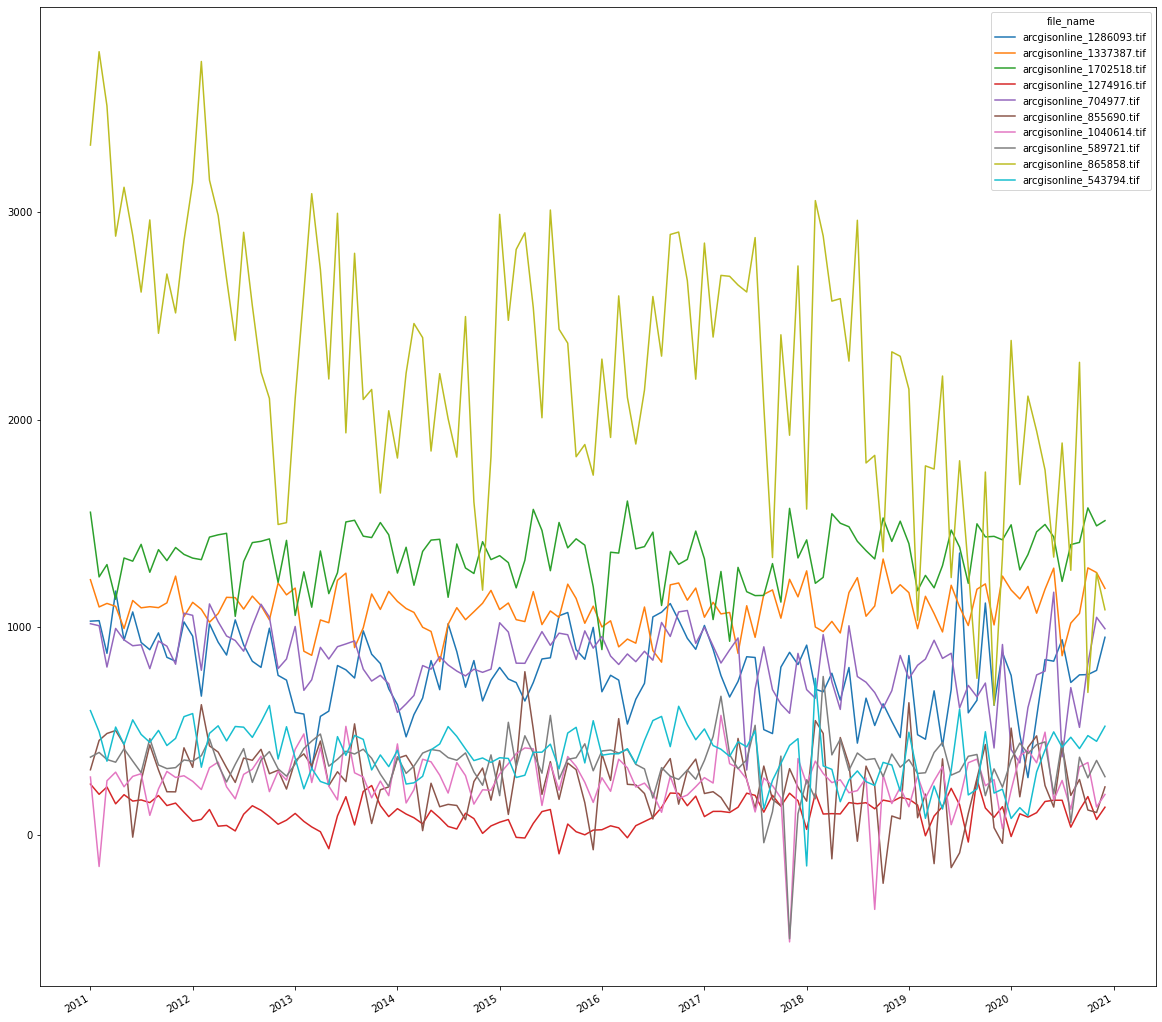

In [83]:
# Plot up some data
dupe_df.iloc[:, : 10].plot.line(figsize=(20,20))